<a href="https://colab.research.google.com/github/HYadh/pie-lasertag/blob/master/descartes_underwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Test Descartes Underwriting par Yadh HAFSI**

---


*Mardi, 22 décembre 2020

# Loading The Packages

In [1882]:
import pandas as pd 
import numpy as np 
import scipy as sp
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA 
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix

# Loading The Data

In [1883]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Lecture des données

In [1884]:
import sys
import pandas as pd 

# Modifier la variable du TD en fonction de l'endroit où les données sont stockées
TD_DIR = 'gdrive/My Drive/Colab Notebooks'
sys.path.append(TD_DIR)
data_train = pd.read_csv(TD_DIR+"/train_auto.csv")
data_test = pd.read_csv(TD_DIR+"/test_auto.csv")

# Data pre-processing

Description des données

In [1885]:
data = data_train.drop(columns=["INDEX"])
#data.columns
data.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


On laisse tomber la variable 'TARGET_AMT' vu qu'elle est fortement corélée à 'TARGET_FLAG' 

In [1886]:
data.drop("TARGET_AMT", inplace = True, axis = 1)

In [1887]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   object 
 6   PARENT1      8161 non-null   object 
 7   HOME_VAL     7697 non-null   object 
 8   MSTATUS      8161 non-null   object 
 9   SEX          8161 non-null   object 
 10  EDUCATION    8161 non-null   object 
 11  JOB          7635 non-null   object 
 12  TRAVTIME     8161 non-null   int64  
 13  CAR_USE      8161 non-null   object 
 14  BLUEBOOK     8161 non-null   object 
 15  TIF          8161 non-null   int64  
 16  CAR_TYPE     8161 non-null   object 
 17  RED_CAR      8161 non-null   object 
 18  OLDCLAIM     8161 non-null   object 
 19  CLM_FR

L'ensemble de données principal comporte 24 features et notre objectif est de prévoir la probabilité de signaler un individu. Notre objectif est la colonne "TARGET_FLAG" qui a deux valeurs : 1 si l'individu est signalé, sinon 0 ; nous sommes désormais dans le cas d'un problème de classification binaire. En ce qui concerne les features elles-mêmes, nous avons 10 features catégoriques et 14 numériques.


# Data Analysis

### Exploration des données

In [1888]:
data.columns

Index(['TARGET_FLAG', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
       'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM',
       'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

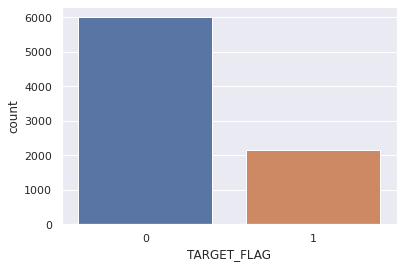

In [1889]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="TARGET_FLAG", data=data)

On constate que la donnée est déséquilibré (unbalanced). Nous aborderons ce problème ultérieurement.

Passons à l'analyse des différents features. On commence par vérifier si le fait d'avoir des enfants à la maison augmente la proba d'être signalé (=Flagged).

In [1890]:
data['HOMEKIDS'].describe()

count    8161.000000
mean        0.721235
std         1.116323
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: HOMEKIDS, dtype: float64

In [1891]:
h_kids = data.groupby(['TARGET_FLAG', 'HOMEKIDS']).size()
h_kids = pd.DataFrame(h_kids)
h_kids.columns = ["Count"]
h_kids

Count
TARGET_FLAG HOMEKIDS       
0           0          4116
            1           597
            2           736
            3           444
            4           107
            5             8
1           0          1173
            1           305
            2           382
            3           230
            4            57
            5             6

On remarque que la probabilité qu'un individu soit signalé augmente lorsqu'il a des enfants à la maison 

---
On peut également jeter un coup d'oeil sur l'impacte de la localisation (milieux urbains/ruraux) sur le nombre 
de signalements.

In [1892]:
localisation = data.groupby(['TARGET_FLAG', 'URBANICITY']).size()
localisation = pd.DataFrame(localisation)
localisation.columns = ["Count"]
localisation

Count
TARGET_FLAG URBANICITY                  
0           Highly Urban/ Urban     4454
            z_Highly Rural/ Rural   1554
1           Highly Urban/ Urban     2038
            z_Highly Rural/ Rural    115

Il est clair que si la vie milieux urbains augmente la probabilité d'être signalé significativement (0.457 en urbain contre 0.074 en rural)



---
Examinons à présent la répartition des différents groupes au sein de nos données


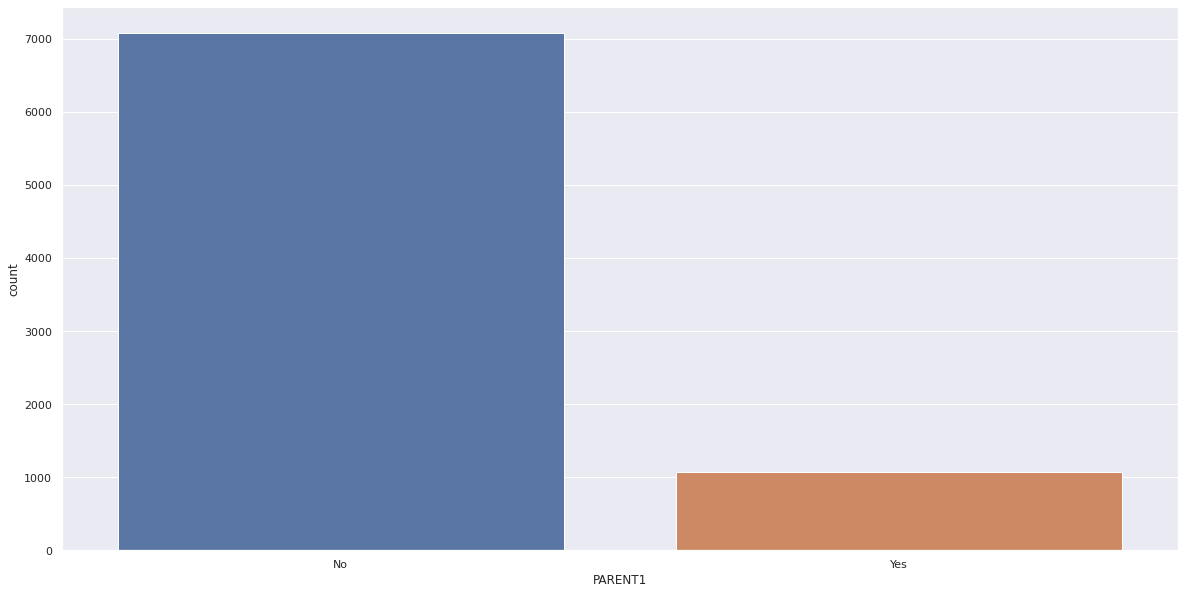

In [1893]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(ax = ax, x=data['PARENT1'])

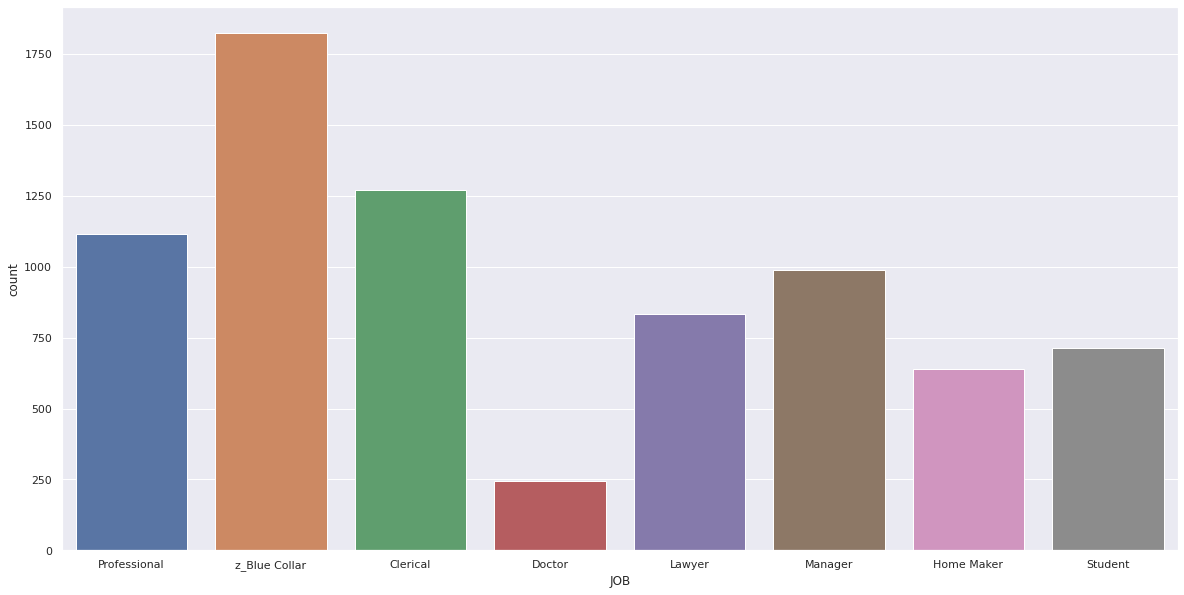

In [1894]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(ax = ax, x=data['JOB'])

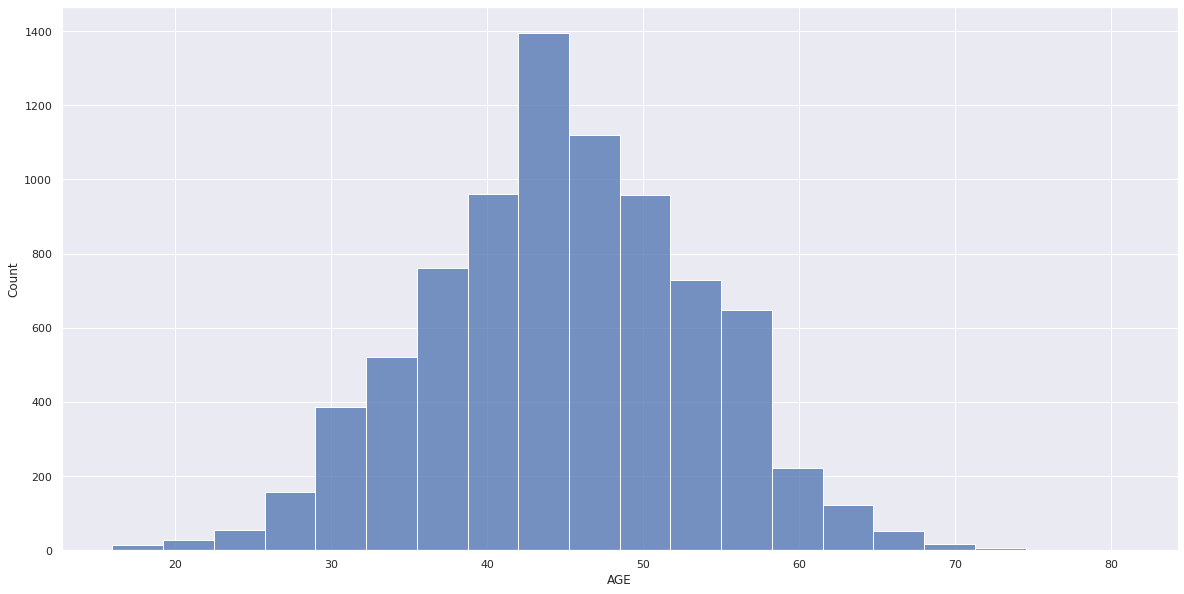

In [1895]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(ax = ax, x=data.loc[:,'AGE'], bins = 20)

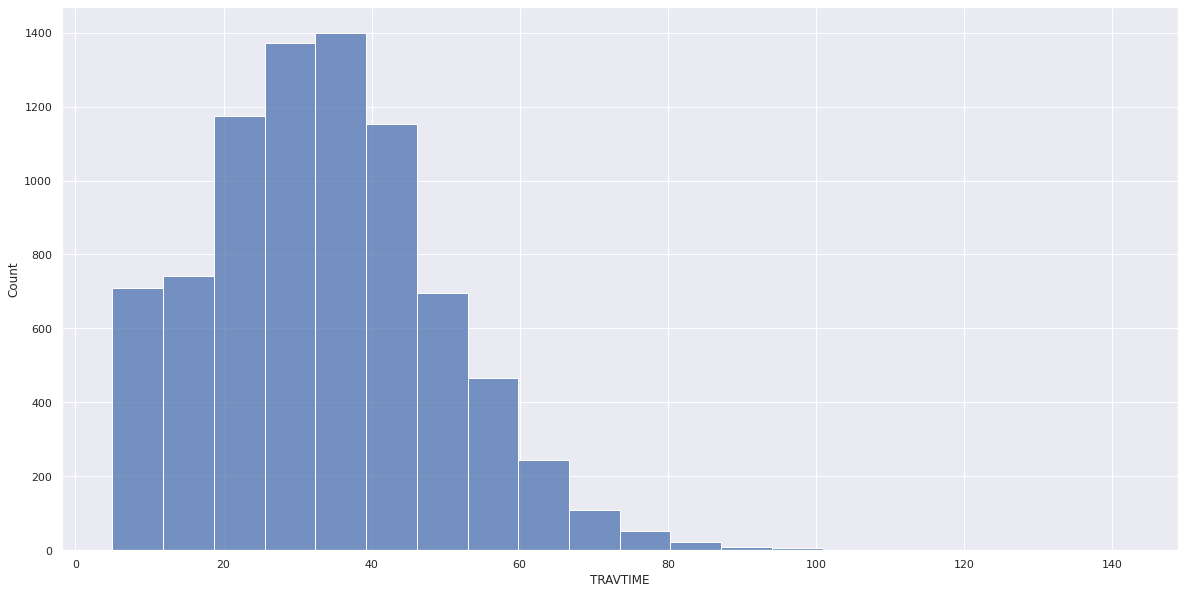

In [1896]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(ax = ax, x=data['TRAVTIME'], bins = 20)

In [1897]:
data['TRAVTIME'].describe()

count    8161.000000
mean       33.485725
std        15.908333
min         5.000000
25%        22.000000
50%        33.000000
75%        44.000000
max       142.000000
Name: TRAVTIME, dtype: float64

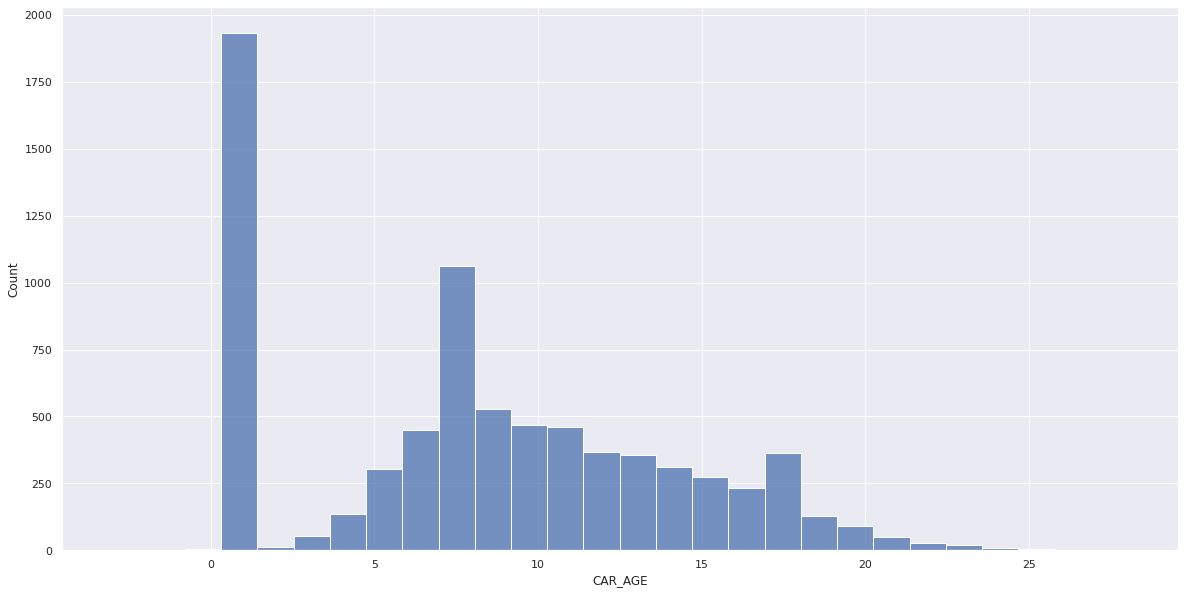

In [1898]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(ax = ax, x=data['CAR_AGE'])

Nous pouvons constater les résultats suivants :


*   Parent : La majorité des individus ne sont pas des parents
*   Travail : La plus part de la population présentée sont des colles bleus
*   Age : L'age observé se situe entre 16 et 81 ans
*   Temps de voyage : Le temps de voyage observé est entre 5h et 142h
*   Age de la voiture: L'age des voitures est entre 0 et 26 ans

Cette analyse préliminéaire n'est pas exaustive et ne vise qu'à nous donner une perspective sur les données qu'on a sous la main.  

# Encodage des variable catégoriques et traitement des valeurs manquantes

On commence par transformer les valeurs numériques présentées sous forme de chaines par des floats.

In [1899]:
nan = type(data['INCOME'][3])
def dollar_float(x):
  y = []
  for i in range(len(x)):
    if (type(x[i]) == nan):
      y.append(x[i])
    elif (x[i] == '$0'):
      y.append(0)
    elif (type(x[i]) != nan and x[i].find(',')>0): 
          
      y.append(float(x[i][1:x[i].find(',')]+x[i][x[i].find(',')+1:]))
    else:
      y.append(float(x[i][1:]))  
  return y    

data['INCOME'] = dollar_float(data['INCOME']) 
data['HOME_VAL'] = dollar_float(data['HOME_VAL']) 
data['BLUEBOOK'] = dollar_float(data['BLUEBOOK']) 
data['OLDCLAIM'] = dollar_float(data['OLDCLAIM']) 


In [1900]:
data['INCOME']

0        67349.0
1        91449.0
2        16039.0
3            NaN
4       114986.0
          ...   
8156     43112.0
8157    164669.0
8158    107204.0
8159     43445.0
8160     53235.0
Name: INCOME, Length: 8161, dtype: float64

In [1901]:
#data.corrplot

On se propose ensuite d'encoder les variable catégoriques et de traiter les valeurs manquantes. Pour ce faire, on rempli les valeurs manquantes des variables numériques par la valeur moyenne de celle-ci et d'affecter les valeurs manquantes des variables catégoriques à une variable "missing" (out of bag). 


In [1902]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

num_variables = ['KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME','HOME_VAL','TRAVTIME', 'BLUEBOOK', 'TIF',
       'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE'
       ]

categorical_varaibles = ['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION',
       'JOB', 'CAR_USE', 'CAR_TYPE', 'RED_CAR',
       'REVOKED','URBANICITY']
                        

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean',missing_values=float('Nan'))), #imputer = remove missing values
    ('scaler',StandardScaler()) #scaler = normalise
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',missing_values=float('Nan'),fill_value='Missing')), #fill NAN values with missing, add a variable called missing
    ('one_hot_encoder',OneHotEncoder())
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_variables),
        ('cat', categorical_transformer, categorical_varaibles),
    ])

### Matrice de corrélation

On commence par observer la matrice de corrélation pour les variables numériques.

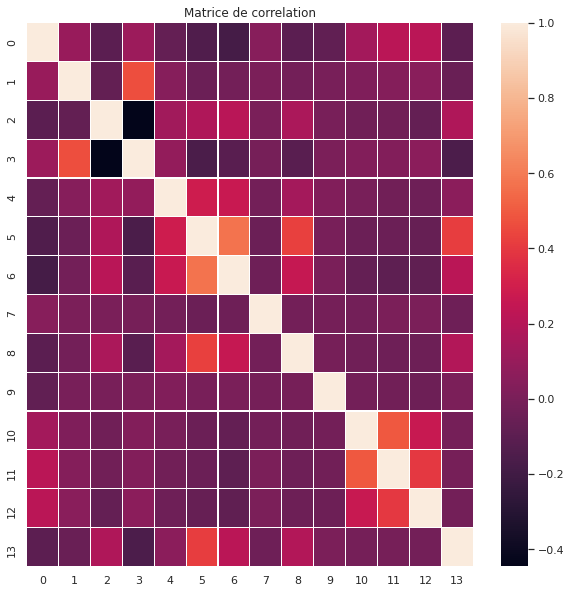

In [1903]:
cor= data.corr()
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cor.to_numpy(),
                 cbar=True,
                 fmt='.2f',
                 annot_kws={'size': 48},
                 linewidths=0.05,
                )
plt.title('Matrice de correlation')
plt.show()

On remarque que les éléments 1 et 3; 5 et 6; 5 et 8; 10 et 11; 11 et 12 sont corrélées. On se propose donc d'effectuer le test H de Kruskal-Wallis pour les échantillons indépendants pour déterminer les features à conserver.

In [1904]:
y = data['TARGET_FLAG']
X = data.drop('TARGET_FLAG',axis = 1)

X = preprocessor.fit_transform(X)

In [1905]:
data.columns

Index(['TARGET_FLAG', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
       'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM',
       'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

In [1906]:
for i,j in enumerate(['KIDSDRIV','HOMEKIDS','INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM',
       'CLM_FREQ', 'MVR_PTS']):
  print("Kruskal test for feautre ",j ," : ",stats.kruskal(X[:,i], y))

Kruskal test for feautre  KIDSDRIV  :  KruskalResult(statistic=8187.163845689667, pvalue=0.0)
Kruskal test for feautre  HOMEKIDS  :  KruskalResult(statistic=291.8887301307687, pvalue=1.9276298441883867e-65)
Kruskal test for feautre  INCOME  :  KruskalResult(statistic=1684.2558614838317, pvalue=0.0)
Kruskal test for feautre  HOME_VAL  :  KruskalResult(statistic=0.393509492319557, pvalue=0.5304604082362974)
Kruskal test for feautre  BLUEBOOK  :  KruskalResult(statistic=798.3617716255699, pvalue=1.2252985400996293e-175)
Kruskal test for feautre  OLDCLAIM  :  KruskalResult(statistic=326.1188754331431, pvalue=6.731570870728428e-73)
Kruskal test for feautre  CLM_FREQ  :  KruskalResult(statistic=549.1336826463977, pvalue=1.942896277463023e-121)
Kruskal test for feautre  MVR_PTS  :  KruskalResult(statistic=904.8505312871918, pvalue=8.657184081892388e-199)


On remarque que l'ensemble des test affichent une p-value inférieur à 0.05 à celui relatif à 'HOME_VAL', on peut donc rejeter 'HOME_VAL'.

In [1907]:
data.drop(columns = ['HOME_VAL'])

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,67349.0,No,z_No,M,PhD,Professional,14,Private,14230.0,11,Minivan,yes,4461.0,2,No,3,18.0,Highly Urban/ Urban
1,0,0,43.0,0,11.0,91449.0,No,z_No,M,z_High School,z_Blue Collar,22,Commercial,14940.0,1,Minivan,yes,0.0,0,No,0,1.0,Highly Urban/ Urban
2,0,0,35.0,1,10.0,16039.0,No,Yes,z_F,z_High School,Clerical,5,Private,4010.0,4,z_SUV,no,38690.0,2,No,3,10.0,Highly Urban/ Urban
3,0,0,51.0,0,14.0,NaN,No,Yes,M,<High School,z_Blue Collar,32,Private,15440.0,7,Minivan,yes,0.0,0,No,0,6.0,Highly Urban/ Urban
4,0,0,50.0,0,NaN,114986.0,No,Yes,z_F,PhD,Doctor,36,Private,18000.0,1,z_SUV,no,19217.0,2,Yes,3,17.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8156,0,0,35.0,0,11.0,43112.0,No,z_No,M,z_High School,z_Blue Collar,51,Commercial,27330.0,10,Panel Truck,yes,0.0,0,No,0,8.0,z_Highly Rural/ Rural
8157,0,1,45.0,2,9.0,164669.0,No,Yes,M,PhD,Manager,21,Private,13270.0,15,Minivan,no,0.0,0,No,2,17.0,Highly Urban/ Urban
8158,0,0,46.0,0,9.0,107204.0,No,Yes,M,Masters,NaN,36,Commercial,24490.0,6,Panel Truck,no,0.0,0,No,0,1.0,Highly Urban/ Urban
8159,0,0,50.0,0,7.0,43445.0,No,Yes,z_F,Bachelors,Home Maker,36,Private,22550.0,6,Minivan,no,0.0,0,No,0,11.0,Highly Urban/ Urban


# Model Training And Prediction

Nous avons constaté que nos données étaient déséquilibrées, nous allons donc essayer différentes approches et comparer leur performances.

Une première approche est de ne rien faire de voir comment notre modèle réagit. Nous essaierons deux modèles : Random forests et XGBoost. Ce choix s'explique par la résistance du Random Forest au sur-apprentissage (over-fitting), par les bonnes performances de XGBoost et par le fait que les méthodes d'ensemble (ensemble methods) en général sont très bonnes pour les problèmes de classification.

Pour chaque modèle, nous effectuerons une validation croisée aléatoire d'une grille de valeurs afin de déterminer les hyperparamètres les mieux adaptés.

La première étape est de diviser le train data-set en données pour d'apprentissage et données pour la validation.

In [1908]:
random_state = 1

y = data['TARGET_FLAG']
X_train, X_test, y_train,y_test = train_test_split(data, y, test_size=0.2, random_state=random_state)
#X_val and y_val seront utilisés pour la validation 
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(X_test.head())

      TARGET_FLAG  KIDSDRIV   AGE  ...  MVR_PTS  CAR_AGE             URBANICITY
3872            0         0  30.0  ...        0      7.0    Highly Urban/ Urban
6261            0         0  20.0  ...        6      6.0  z_Highly Rural/ Rural
2394            0         1  41.0  ...        4     14.0    Highly Urban/ Urban
5150            1         0  64.0  ...        4      8.0    Highly Urban/ Urban
2851            0         0  40.0  ...        3      8.0    Highly Urban/ Urban

[5 rows x 24 columns]


## Première approche: Do nothing

La métrique utilisée ici et par la suite est 'accuracy_score';  il s'agit simplement d'un rapport entre le nombre d'observation correctement prédite et le nombre total des observations. Ce choix est justifié par le fait qu'il n'y a pas de préférence entre les faux positifs et les faux négatifs dans ce problème.
On se propose de commencer par implémenter un **arbre de décision**. 

In [1909]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.pipeline import make_pipeline

enc_cat_features = preprocessor.named_transformers_['cat']['one_hot_encoder'].get_feature_names(categorical_varaibles)
labels = np.concatenate([num_variables, enc_cat_features
                        ])


Calcul et affichage de l'exactitude en fonction de la profondeur de l'**arbre de décision**

Accuracy is 0.7624004898958971


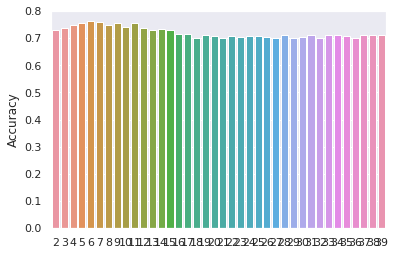

In [1910]:
L = []
for i in range(2,40):
    model_dt = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth=i)
)
    model_dt.fit(X_train, y_train)
    y_pred = model_dt.predict(X_test)
    Accuracy = sklearn.metrics.accuracy_score(y_test,y_pred)
    L.append(Accuracy)
    
Accuracy_df = pd.DataFrame(data = {'Accuracy' : L},index = range(2,40))
sns.barplot(x= Accuracy_df.index, y =Accuracy_df["Accuracy"])
print("Accuracy is "+str(max(L)))


Test accuracy & validation accuracy

In [1911]:
model_dt = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth=list(Accuracy_df['Accuracy']).index(max(L))))
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test)

print("test score accuracy",model_dt.score(X_test,y_test))
print("Validation score accuracy",model_dt.score(X_val,y_val))

test score accuracy 0.7501530924678506
Validation score accuracy 0.7487745098039216


In [1912]:
labels

array(['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL',
       'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS',
       'CAR_AGE', 'PARENT1_No', 'PARENT1_Yes', 'MSTATUS_Yes',
       'MSTATUS_z_No', 'SEX_M', 'SEX_z_F', 'EDUCATION_<High School',
       'EDUCATION_Bachelors', 'EDUCATION_Masters', 'EDUCATION_PhD',
       'EDUCATION_z_High School', 'JOB_Clerical', 'JOB_Doctor',
       'JOB_Home Maker', 'JOB_Lawyer', 'JOB_Manager', 'JOB_Missing',
       'JOB_Professional', 'JOB_Student', 'JOB_z_Blue Collar',
       'CAR_USE_Commercial', 'CAR_USE_Private', 'CAR_TYPE_Minivan',
       'CAR_TYPE_Panel Truck', 'CAR_TYPE_Pickup', 'CAR_TYPE_Sports Car',
       'CAR_TYPE_Van', 'CAR_TYPE_z_SUV', 'RED_CAR_no', 'RED_CAR_yes',
       'REVOKED_No', 'REVOKED_Yes', 'URBANICITY_Highly Urban/ Urban',
       'URBANICITY_z_Highly Rural/ Rural'], dtype=object)

In [1913]:
model

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                          

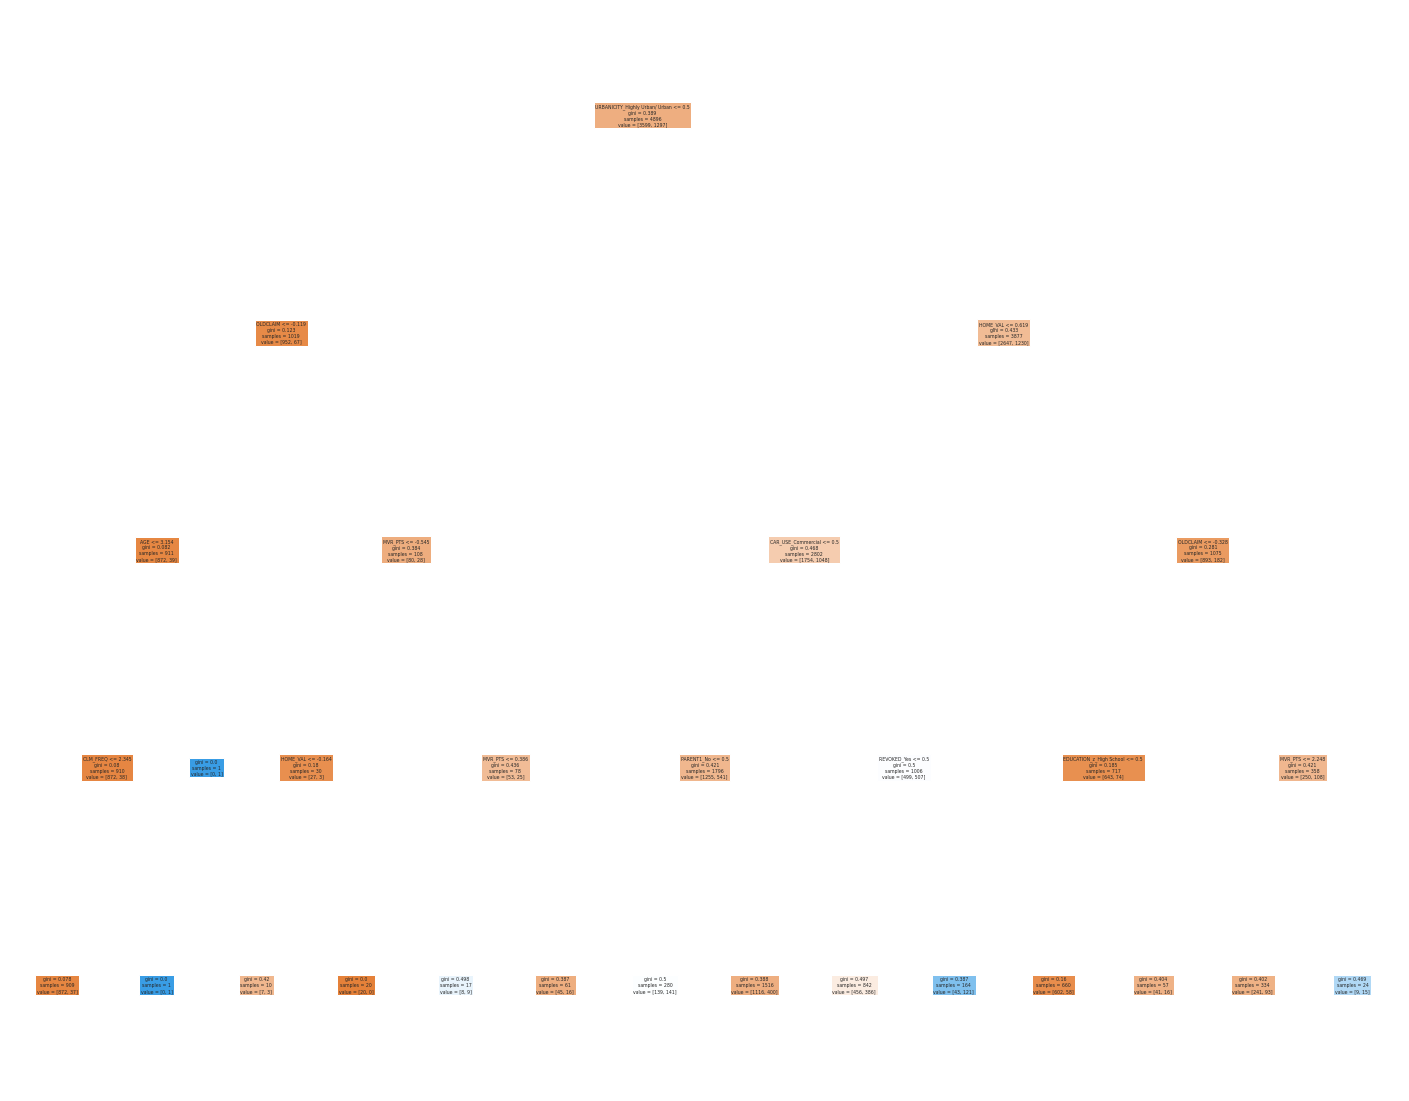

In [1914]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(model_dt[1], 
            feature_names=labels,
            filled=True)

Essayons de classer les features selon leurs importances

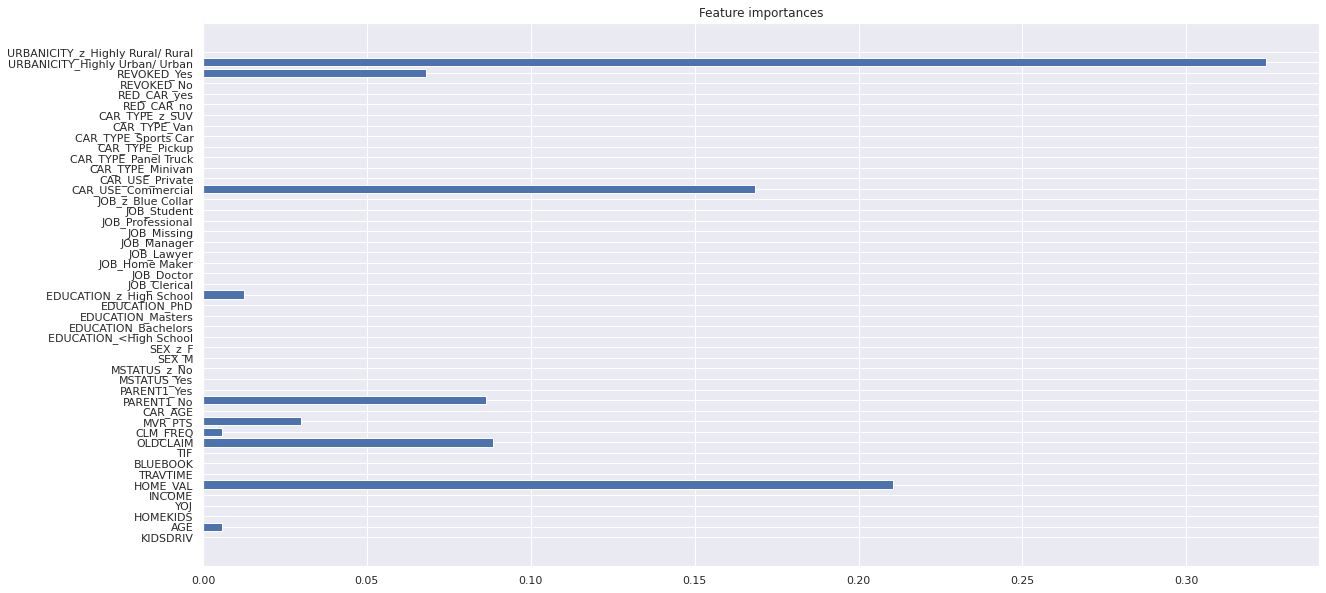

In [1915]:
importances = model_dt.get_params()['decisiontreeclassifier'].feature_importances_
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.barh(labels, importances)
plt.xticks(rotation=0)
plt.show()

On décide ensuite d'essayer le modèle **Random Forest**

In [1916]:
#preprocessor.fit_transform(X_train).shape

Calcul et affichage de l'exactitude en fonction du nombre d'estimateurs du classifieur **Random Forest**

In [1917]:
L = []
for i in range(2,40):
    model_rf = make_pipeline(
        preprocessor,
        RandomForestClassifier(n_estimators=i)
    )
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_test)
    Accuracy = sklearn.metrics.accuracy_score(y_test,y_pred)
    L.append(Accuracy)
    


Accuracy is 0.8028169014084507


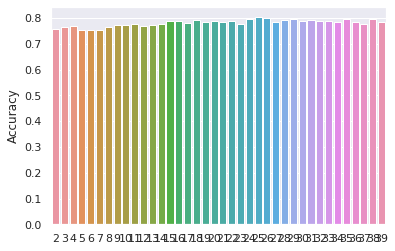

In [1918]:
Accuracy_df = pd.DataFrame(data = {'Accuracy' : L},index = range(2,40))
sns.barplot(x= Accuracy_df.index, y =Accuracy_df["Accuracy"])
print("Accuracy is "+str(max(L)))

On peut dors et déjà noter que la performance du classifieur Random forest est meilleur que celle d'un arbre de décision. Voyons ce qu'il en est des features les plus significatifs.

Test accuracy & validation accuracy

In [1919]:
model_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=list(Accuracy_df['Accuracy']).index(max(L))))
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

print("test score accuracy",sklearn.metrics.accuracy_score(y_test,y_pred))
print("Validation score accuracy",model_rf.score(X_val,y_val))

test score accuracy 0.7875076546233926
Validation score accuracy 0.7800245098039216


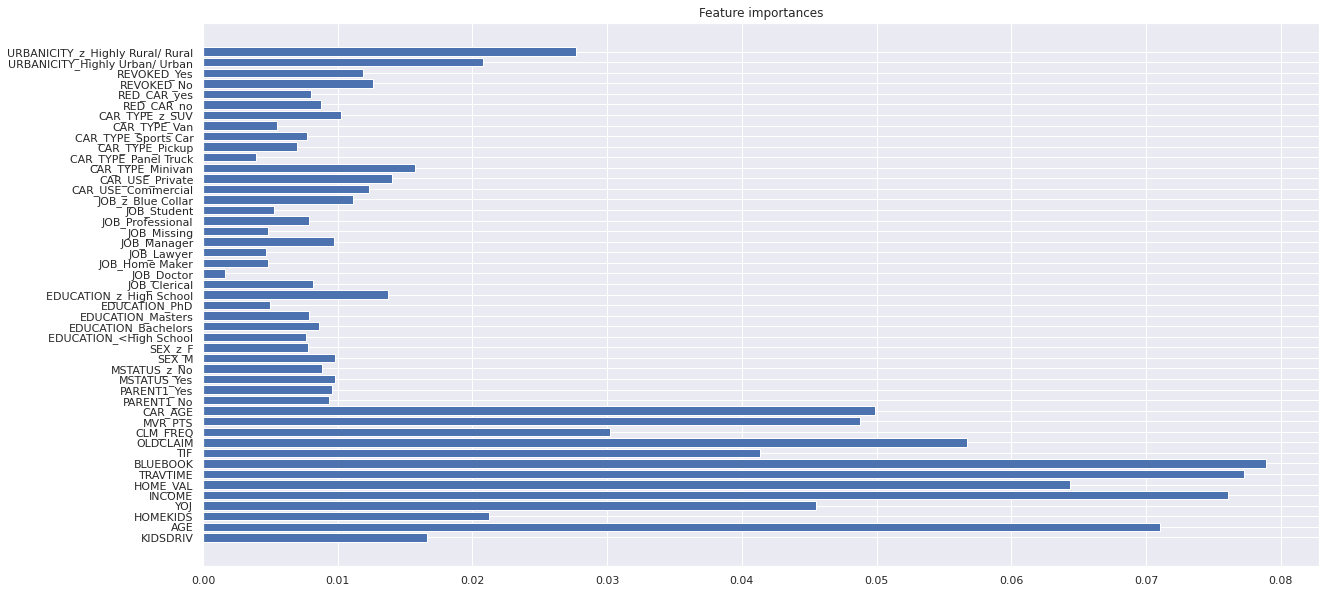

In [1920]:
importances = model_rf.get_params()['randomforestclassifier'].feature_importances_
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.barh(labels, importances)
plt.xticks(rotation=0)
plt.show()

On se propose désormais d'essayer de classifier les données avec le classifieur **Gradient Boosting**

Accuracy is 0.7875076546233926


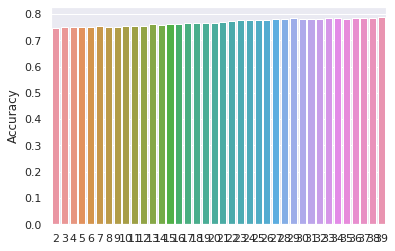

In [1921]:
L = []
for i in range(2,40):
    model_gb = make_pipeline(
        preprocessor,
        xgb.XGBClassifier(n_estimators=i)
    )
    model_gb.fit(X_train, y_train)
    y_pred = model_gb.predict(X_test)
    Accuracy = sklearn.metrics.accuracy_score(y_test,y_pred)
    L.append(Accuracy)
    
Accuracy_df = pd.DataFrame(data = {'Accuracy' : L},index = range(2,40))
sns.barplot(x= Accuracy_df.index, y =Accuracy_df["Accuracy"])
print("Accuracy is "+str(max(L)))

Test accuracy & validation accuracy

In [1922]:
model_gb = make_pipeline(
    preprocessor,
    xgb.XGBClassifier(n_estimators=list(Accuracy_df['Accuracy']).index(max(L))))
model_gb.fit(X_train, y_train)
y_pred = model_gb.predict(X_test)

print("test score accuracy",model_gb.score(X_test,y_test))
print("Validation score accuracy",model_gb.score(X_val,y_val))

test score accuracy 0.7850581751377832
Validation score accuracy 0.7794117647058824


=> La performance de la Random forest est encore une fois meilleure

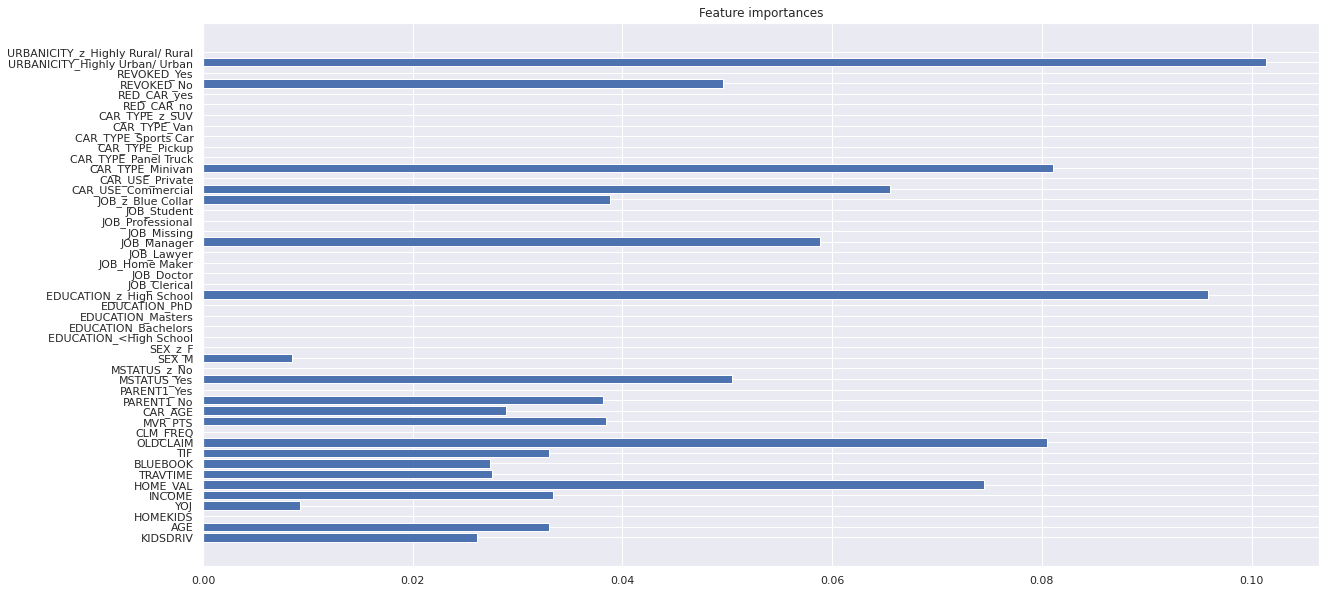

In [1923]:
importances = model_gb.get_params()['xgbclassifier'].feature_importances_
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.barh(labels, importances)
plt.xticks(rotation=0)
plt.show()

## Deuxième approche: Using Oversampling

In [1924]:
# On commence par utiliser SMOTE 
sm = SMOTE()

y = data['TARGET_FLAG']
X = data.drop('TARGET_FLAG',axis = 1)

X = preprocessor.fit_transform(X)

X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test  = train_test_split(X_res, y_res, test_size=0.2, random_state=1)
#X_val and y_val seront utilisés pour la validation
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [1925]:
X_train

array([[-0.3344214 ,  1.64771231, -0.64612047, ...,  0.        ,
         1.        ,  0.        ],
       [-0.3344214 ,  1.41579836, -0.64612047, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.62060229, -0.55547015,  2.04143773, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.3344214 , -0.20759924,  0.24973226, ...,  0.        ,
         1.        ,  0.        ],
       [-0.3344214 , -0.81133918,  2.04143773, ...,  1.        ,
         1.        ,  0.        ],
       [-0.3344214 , -1.71503987,  0.24973226, ...,  0.        ,
         1.        ,  0.        ]])

On réitère les méthodes Random Forest et Gradient Boosting après avoir rééquilibré la data

**Random Forest**

Accuracy is 0.8585690515806988


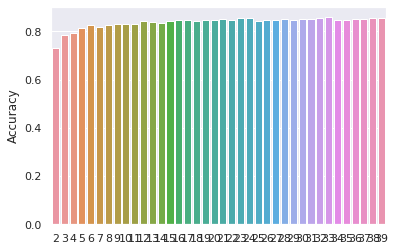

In [1926]:
L = []
for i in range(2,40):
    model_rf = RandomForestClassifier(n_estimators=i) 
    model_rf.fit(X_train, y_train) 
    Accuracy = model_rf.score(X_test,y_test)
    L.append(Accuracy)
    
Accuracy_df = pd.DataFrame(data = {'Accuracy' : L},index = range(2,40))
sns.barplot(x= Accuracy_df.index, y =Accuracy_df["Accuracy"])
print("Accuracy is "+str(max(L)))

In [1927]:
model_rf = RandomForestClassifier(n_estimators=list(Accuracy_df['Accuracy']).index(max(L)))
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

print("test score accuracy",model_rf.score(X_test,y_test))
print("Validation score accuracy",model_rf.score(X_val,y_val))

test score accuracy 0.8535773710482529
Validation score accuracy 0.8601747815230961


**Gradient Boosting**

Accuracy is 0.8182196339434277


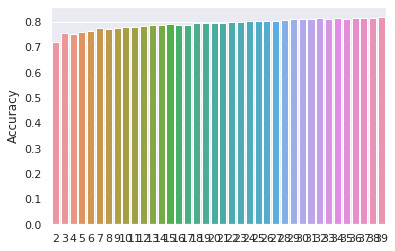

In [1928]:
L = []
for i in range(2,40):
  model_gb = xgb.XGBClassifier(n_estimators=i)
  model_gb.fit(X_train, y_train)
  y_pred = model_gb.predict(X_test)
  Accuracy = sklearn.metrics.accuracy_score(y_test,y_pred)
  L.append(Accuracy)
    
Accuracy_df = pd.DataFrame(data = {'Accuracy' : L},index = range(2,40))
sns.barplot(x= Accuracy_df.index, y =Accuracy_df["Accuracy"])
print("Accuracy is "+str(max(L)))

In [1929]:
model_gb = xgb.XGBClassifier(n_estimators=list(Accuracy_df['Accuracy']).index(max(L)))
model_gb.fit(X_train, y_train)
y_pred = model_gb.predict(X_test)

print("test score accuracy",model_gb.score(X_test,y_test))
print("Validation score accuracy",model_gb.score(X_val,y_val))

test score accuracy 0.8161397670549085
Validation score accuracy 0.8214731585518102


=> La performance des deux méthodes s'est améliorée mais le classifieur Random Forest est toujours plus performant.

# Conclusion

Pour conclure, on constate que le suréchantillonnage permet de faire face au problème causé par le déséquiblibre des données (unbalanced data) et d'améliorer la capacité des classifieurs qu'on a utilisé à prédire la variable 'TARGET_FLAG'. 

Une façon d'améliorer les résultats est d'obtenir des données plus réelles est d'essayer de les équilibrer sans utiliser de méthodes de rééchantillonnage (En utilisant des balanced algorithms directement comme HistGradientBoostingClassifier). Nous pourrions également expérimenter d'autres modèles prédictifs tels que les arbres de décision, la régression logistique et les MVC, mais les méthodes d'ensemble restent des classificateurs très robustes. Une autre approche complètement différente consiste à utiliser les réseaux de neurones, car ils peuvent être très efficaces dans les scénarios prédictifs, mais comme les données ne sont pas vraiment si complexes, leur puissance n'est pas très importante par rapport aux méthodes d'ensemble.

Il est à noter qu'une optimisation plus poussé des hyperparamètres (En utilisant RandomizedSearchCV par exemple) aurait certainement améliorée les résultats obtenus en terme de performance. Nous avons ici choisi de n'optimiser qu'une seule variable pour chacun des algorithmes utilisés pour diminuer leurs temps d'éxécution.